# LetsGrowMore Internship

# Task 2(Beginner Level)

# Task - Stock Market Prediction And Forecasting Using Stacked LSTM

# by Mrinal Kumar(Batch - March 2023)

# 

# 

# Importing Libraries

In [1]:
# import libraries

import numpy as np
import pandas as pd

# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# for creating LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import tensorflow as tf

In [2]:
from datetime import datetime, timedelta


import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install numpy==1.21

In [4]:
# read dataset
df = pd.read_csv(r'C:\Users\Mrinal\Desktop\Lets_grow_more\letsgrowmore_stock_market_prediction_and_forecasting_task\Dataset_stockmarket.csv')

In [5]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,28-09-2018,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,27-09-2018,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,26-09-2018,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,25-09-2018,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,24-09-2018,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


# Data Exploration

In [6]:
# check shape of data
df.shape

(2035, 8)

In [7]:
# checking null values
df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [8]:
# check basic info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [9]:
# get statistical summaries of dataset
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


# Exploratory Data Analysis (EDA)

Data Visualization

In [10]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')

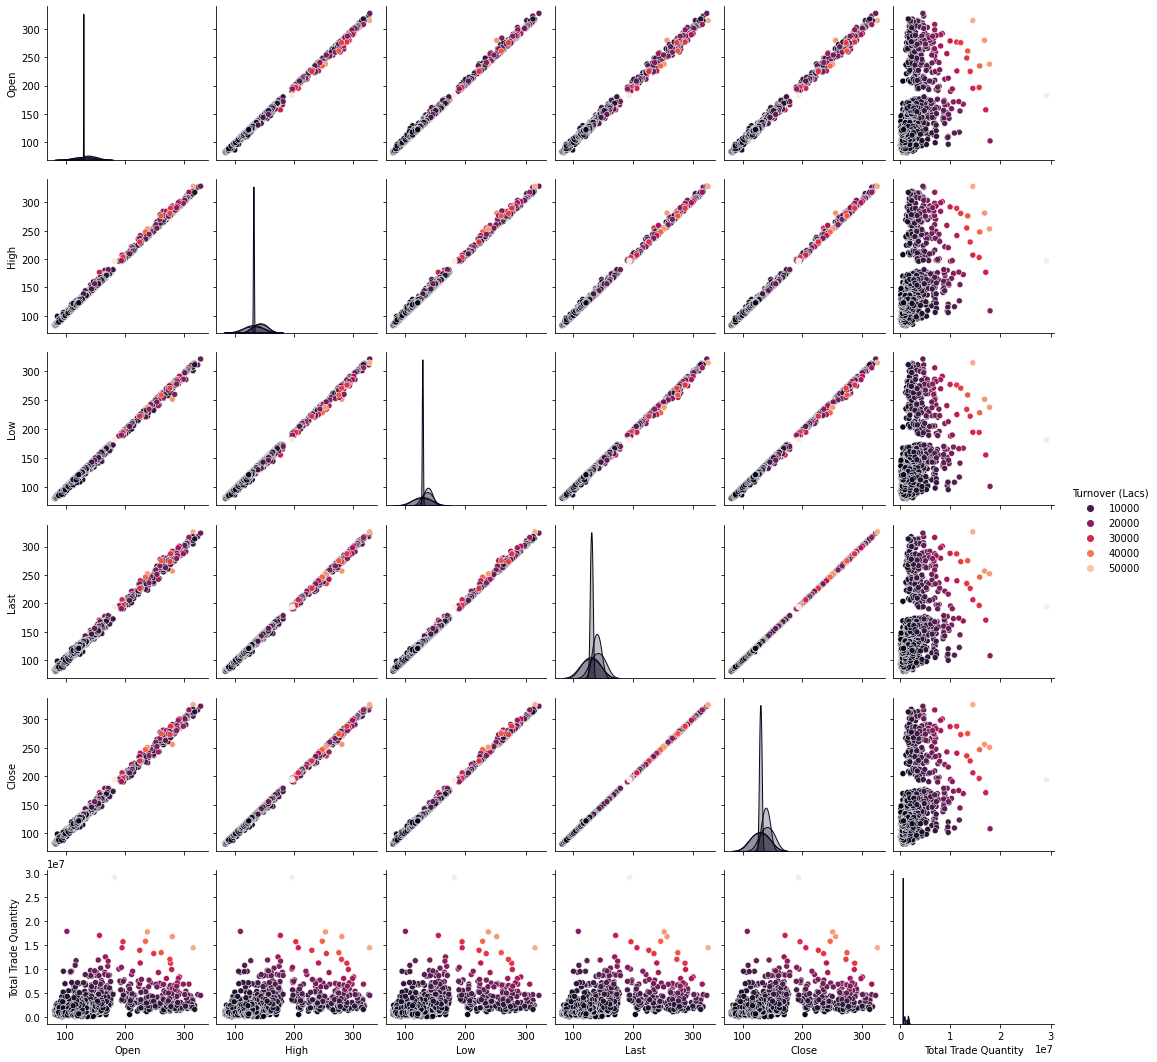

In [11]:
sns.pairplot(df, hue= 'Turnover (Lacs)', palette='rocket')
plt.show()

In [12]:
df_close = df.reset_index()['Close'] # The reset_index() method allows you reset the index back to the default 0, 1, 2 etc indexes.
df_close

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

Let us plot the close value graph using pyplot

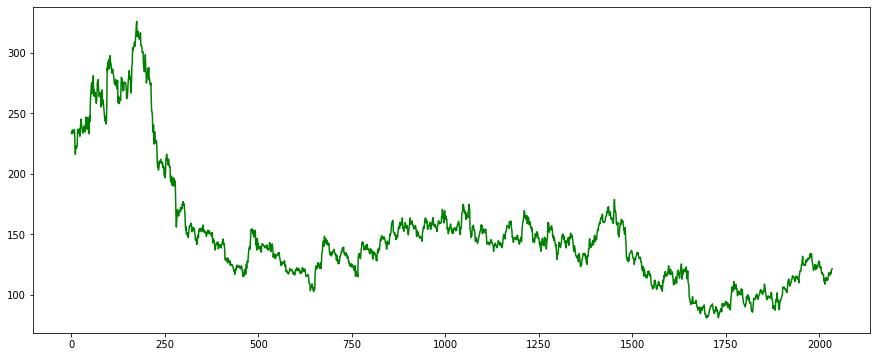

In [13]:
plt.figure(figsize=(15,6))
plt.plot(df_close, c='g')
plt.show()

Let us plot High value graph using pyplot

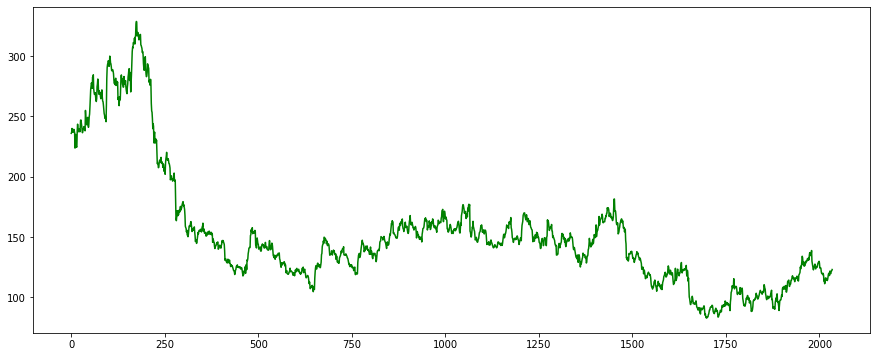

In [14]:
plt.figure(figsize=(15,6))

df_high = df.reset_index()['High']
plt.plot(df_high, c='g')
plt.show()

Since LSTM is sensetive to the scale of data. so we apply MinMax Scaler to Transform our values between 0 and 1

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df_high = scaler.fit_transform(np.array(df_high).reshape(-1,1)) #-1 in reshape function is used when you dont know or want 
                                                                # to explicitly tell the dimension of that axis.
                                                                #E.g,
                                                                # If you have an array of shape (2,4) then reshaping it with
                                                                # (-1, 1), then the array will get reshaped in such a way that 
                                                                # the resulting array has only 1 column and this is only
                                                                # possible by having 8 rows, hence, (8,1)

In [16]:
df_high.shape

(2035, 1)

In [17]:
print(df_high)

[[0.62268754]
 [0.62614353]
 [0.6391543 ]
 ...
 [0.15917869]
 [0.15938199]
 [0.16344786]]


# Train Test Split

In time-series data the one data is dependent on other data. The training side should be 75% of the total length of the data frame, The test size should be the difference between the length of the dataset and the training size

In [18]:
training_size = int(len(df_high)*0.75)
test_size = len(df_high) - training_size
train_data, test_data = df_high[0:training_size,:], df_high[training_size:len(df_high),:1]

In [19]:
training_size, test_size

(1526, 509)

In [20]:
train_data

array([[0.62268754],
       [0.62614353],
       [0.6391543 ],
       ...,
       [0.18906282],
       [0.18377719],
       [0.16487091]])

In [21]:
train_data.shape

(1526, 1)

In [22]:
test_data

array([[0.16731043],
       [0.16446432],
       [0.17157959],
       [0.1681236 ],
       [0.14881073],
       [0.16161822],
       [0.16100834],
       [0.15125025],
       [0.13864607],
       [0.13254727],
       [0.13681643],
       [0.140679  ],
       [0.14088229],
       [0.13579996],
       [0.14250864],
       [0.14921732],
       [0.15165684],
       [0.15450295],
       [0.15084367],
       [0.14921732],
       [0.14413499],
       [0.14637121],
       [0.14291523],
       [0.1345802 ],
       [0.11669038],
       [0.10672901],
       [0.10367961],
       [0.10002033],
       [0.09737752],
       [0.10733889],
       [0.10245985],
       [0.10957512],
       [0.12197601],
       [0.12339906],
       [0.12787152],
       [0.12156942],
       [0.11038829],
       [0.10611913],
       [0.10124009],
       [0.09026225],
       [0.10774548],
       [0.10774548],
       [0.11242122],
       [0.12360236],
       [0.11811344],
       [0.10855865],
       [0.11547062],
       [0.109

# Data Preprocessing

In [23]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# LSTM

Reshape the input to be[samples, time steps, features]which is requirement of LSTM

Always remember whenever we are implementing LSTM, we have to always reshape our data into 3D 
(i.e. [samples(no. of rows), timesteps(no. of columns), features(1-use one here for converting into 3d)])

In [25]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1) # x.shape[0] will give the number of rows in an array. In your case it will give output 10. If you will type x.shape[1], it will print out the number of columns
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [26]:
print(x_train.shape), print(y_train.shape)

(1425, 100, 1)
(1425,)


(None, None)

In [27]:
print(x_test.shape), print(y_test.shape)

(408, 100, 1)
(408,)


(None, None)

import required modules for the stacked LSTM

In [28]:
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [29]:
# checking tensorflow version
tf.__version__

'2.8.0-dev20211214'

In [30]:
# Create the LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))                                                 # neural network node/outputnode, I need just one output 
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

input_shape = (n_steps, n_features)

n_features = features(1-use one here for converting into 3d)
n_steps = time_step(time_step = 100) --> n_steps=no. of timesteps

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 11s 197ms/step - loss: 0.0210 - val_loss: 0.0070
Epoch 2/100
23/23 [==============================] - 3s 125ms/step - loss: 0.0023 - val_loss: 9.3059e-04
Epoch 3/100
23/23 [==============================] - 3s 128ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 4/100
23/23 [==============================] - 3s 127ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/100
23/23 [==============================] - 3s 125ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/100
23/23 [==============================] - 3s 124ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/100
23/23 [==============================] - 3s 128ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/100
23/23 [==============================] - 3s 128ms/step - loss: 0.0012 - val_loss: 8.8580e-04
Epoch 9/100
23/23 [==============================] - 3s 134ms/step - loss: 0.0010 - val_loss: 9.8802e-04
Epoch 10/100
23/23 [==============================] - 3s 125ms/step - loss: 9.

23/23 [==============================] - 3s 135ms/step - loss: 2.1759e-04 - val_loss: 3.2153e-04
Epoch 77/100
23/23 [==============================] - 3s 132ms/step - loss: 2.1281e-04 - val_loss: 2.0435e-04
Epoch 78/100
23/23 [==============================] - 3s 141ms/step - loss: 1.8670e-04 - val_loss: 2.0540e-04
Epoch 79/100
23/23 [==============================] - 3s 132ms/step - loss: 1.7959e-04 - val_loss: 2.3296e-04
Epoch 80/100
23/23 [==============================] - 3s 127ms/step - loss: 1.8503e-04 - val_loss: 1.9905e-04
Epoch 81/100
23/23 [==============================] - 3s 131ms/step - loss: 2.1065e-04 - val_loss: 1.7313e-04
Epoch 82/100
23/23 [==============================] - 3s 129ms/step - loss: 3.3015e-04 - val_loss: 3.0157e-04
Epoch 83/100
23/23 [==============================] - 3s 143ms/step - loss: 2.2343e-04 - val_loss: 1.6327e-04
Epoch 84/100
23/23 [==============================] - 3s 133ms/step - loss: 1.7593e-04 - val_loss: 1.5944e-04
Epoch 85/100
23/23 [===

verbose = 1 --> means we will able to see how all the epoch how it is getting placed

In [37]:
# lets check performance matrics

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [38]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [39]:
# Calculate RMSE performance metrics

math.sqrt(mean_squared_error(y_train, train_predict))

165.42000348871179

In [40]:
# teat data RMSE

math.sqrt(mean_squared_error(y_test, test_predict))

107.5856751679346

# Plotting the graph according to train and test data

In [41]:
# Plotting

#shift train prediction for plotting
look_back=100
trainPredictPlot = np.empty_like(df_high)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#shift test prediction for plotting
testPredictPlot = np.empty_like(df_high)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_high) - 1,:] = test_predict

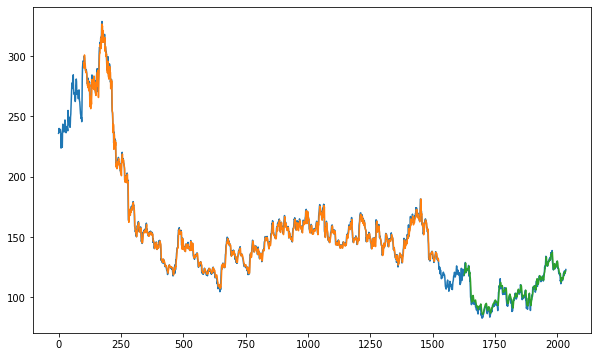

Green indicates the Predicted data
Blue indicates the Complete data
Orange indicates the Train data


In [42]:
#Plot baseline and predictions
plt.figure(figsize = (10,6))

plt.plot(scaler.inverse_transform(df_high))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print('Green indicates the Predicted data')
print('Blue indicates the Complete data')
print('Orange indicates the Train data')

In [43]:
# Predict the next 28 days stock Price
len(test_data), x_test.shape

(509, (408, 100, 1))

In [44]:
x_input = test_data[409:].reshape(1,-1) # len(test_data)=509, since time_step=100, so I have to take previous 100 data i.e, 409 to 509
x_input.shape

(1, 100)

In [45]:
print(x_input)

[[0.1345802  0.13254727 0.13397032 0.13356373 0.13498679 0.14108559
  0.13498679 0.12644847 0.12685505 0.12482212 0.14515145 0.1467778
  0.15003049 0.15368977 0.17198618 0.16548079 0.17625534 0.17564546
  0.19129904 0.20817239 0.20309006 0.18479366 0.17930474 0.1896727
  0.17483228 0.17849156 0.17645863 0.18540354 0.18377719 0.19190892
  0.18987599 0.19028258 0.19394186 0.20004066 0.19638138 0.19495832
  0.20349665 0.19597479 0.21162838 0.22036999 0.20979874 0.21528766
  0.21589754 0.21610083 0.22748526 0.19150234 0.1833706  0.17340923
  0.16751372 0.1622281  0.17056312 0.17462899 0.17930474 0.18174426
  0.16853019 0.16548079 0.1742224  0.1713763  0.17300264 0.17157959
  0.17767839 0.18459036 0.18702988 0.18987599 0.19109575 0.18581012
  0.17015654 0.16751372 0.16974995 0.16609067 0.15531612 0.15003049
  0.15064037 0.14860744 0.14596463 0.15043708 0.14413499 0.12441553
  0.12827811 0.11547062 0.12034966 0.13478349 0.13498679 0.12868469
  0.13295385 0.12807481 0.12624517 0.13051433 0.13

In [46]:
print(x_input[0])

[0.1345802  0.13254727 0.13397032 0.13356373 0.13498679 0.14108559
 0.13498679 0.12644847 0.12685505 0.12482212 0.14515145 0.1467778
 0.15003049 0.15368977 0.17198618 0.16548079 0.17625534 0.17564546
 0.19129904 0.20817239 0.20309006 0.18479366 0.17930474 0.1896727
 0.17483228 0.17849156 0.17645863 0.18540354 0.18377719 0.19190892
 0.18987599 0.19028258 0.19394186 0.20004066 0.19638138 0.19495832
 0.20349665 0.19597479 0.21162838 0.22036999 0.20979874 0.21528766
 0.21589754 0.21610083 0.22748526 0.19150234 0.1833706  0.17340923
 0.16751372 0.1622281  0.17056312 0.17462899 0.17930474 0.18174426
 0.16853019 0.16548079 0.1742224  0.1713763  0.17300264 0.17157959
 0.17767839 0.18459036 0.18702988 0.18987599 0.19109575 0.18581012
 0.17015654 0.16751372 0.16974995 0.16609067 0.15531612 0.15003049
 0.15064037 0.14860744 0.14596463 0.15043708 0.14413499 0.12441553
 0.12827811 0.11547062 0.12034966 0.13478349 0.13498679 0.12868469
 0.13295385 0.12807481 0.12624517 0.13051433 0.13905265 0.147184

# Predicting values of next 30 days

In [48]:
temp_input = list(x_input) # after taking previous 100 test_data, we are going to convert x_input to list
temp_input = temp_input[0].tolist() # tolist(), used to convert the data elements of an array into a list and taking all the values.
lst_output=[]
n_steps=100
nextNumberOfDays = 28
i=0

while (i<nextNumberOfDays):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print('{} day input {}'.format(i, x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        y_hat = model.predict(x_input, verbose=0)
        print('{} day output {}'.format(i, y_hat))
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(y_hat.tolist())
        i=i+1
    
    else:
        x_input = x_input.reshape((1, n_steps,1))
        y_hat = model.predict(x_input, verbose=0)
        print(y_hat[0])
        temp_input.extend(y_hat[0].tolist())
        print(len(temp_input))
        lst_output.extend(y_hat.tolist())
        i=i+1
print(lst_output)

[0.16334255]
101
1 day input [0.13254727 0.13397032 0.13356373 0.13498679 0.14108559 0.13498679
 0.12644847 0.12685505 0.12482212 0.14515145 0.1467778  0.15003049
 0.15368977 0.17198618 0.16548079 0.17625534 0.17564546 0.19129904
 0.20817239 0.20309006 0.18479366 0.17930474 0.1896727  0.17483228
 0.17849156 0.17645863 0.18540354 0.18377719 0.19190892 0.18987599
 0.19028258 0.19394186 0.20004066 0.19638138 0.19495832 0.20349665
 0.19597479 0.21162838 0.22036999 0.20979874 0.21528766 0.21589754
 0.21610083 0.22748526 0.19150234 0.1833706  0.17340923 0.16751372
 0.1622281  0.17056312 0.17462899 0.17930474 0.18174426 0.16853019
 0.16548079 0.1742224  0.1713763  0.17300264 0.17157959 0.17767839
 0.18459036 0.18702988 0.18987599 0.19109575 0.18581012 0.17015654
 0.16751372 0.16974995 0.16609067 0.15531612 0.15003049 0.15064037
 0.14860744 0.14596463 0.15043708 0.14413499 0.12441553 0.12827811
 0.11547062 0.12034966 0.13478349 0.13498679 0.12868469 0.13295385
 0.12807481 0.12624517 0.13051433

8 day output [[0.1693801]]
9 day input [0.12482212 0.14515145 0.1467778  0.15003049 0.15368977 0.17198618
 0.16548079 0.17625534 0.17564546 0.19129904 0.20817239 0.20309006
 0.18479366 0.17930474 0.1896727  0.17483228 0.17849156 0.17645863
 0.18540354 0.18377719 0.19190892 0.18987599 0.19028258 0.19394186
 0.20004066 0.19638138 0.19495832 0.20349665 0.19597479 0.21162838
 0.22036999 0.20979874 0.21528766 0.21589754 0.21610083 0.22748526
 0.19150234 0.1833706  0.17340923 0.16751372 0.1622281  0.17056312
 0.17462899 0.17930474 0.18174426 0.16853019 0.16548079 0.1742224
 0.1713763  0.17300264 0.17157959 0.17767839 0.18459036 0.18702988
 0.18987599 0.19109575 0.18581012 0.17015654 0.16751372 0.16974995
 0.16609067 0.15531612 0.15003049 0.15064037 0.14860744 0.14596463
 0.15043708 0.14413499 0.12441553 0.12827811 0.11547062 0.12034966
 0.13478349 0.13498679 0.12868469 0.13295385 0.12807481 0.12624517
 0.13051433 0.13905265 0.14718439 0.15104696 0.14515145 0.14311852
 0.15816223 0.15328319 0

16 day output [[0.17275542]]
17 day input [0.17564546 0.19129904 0.20817239 0.20309006 0.18479366 0.17930474
 0.1896727  0.17483228 0.17849156 0.17645863 0.18540354 0.18377719
 0.19190892 0.18987599 0.19028258 0.19394186 0.20004066 0.19638138
 0.19495832 0.20349665 0.19597479 0.21162838 0.22036999 0.20979874
 0.21528766 0.21589754 0.21610083 0.22748526 0.19150234 0.1833706
 0.17340923 0.16751372 0.1622281  0.17056312 0.17462899 0.17930474
 0.18174426 0.16853019 0.16548079 0.1742224  0.1713763  0.17300264
 0.17157959 0.17767839 0.18459036 0.18702988 0.18987599 0.19109575
 0.18581012 0.17015654 0.16751372 0.16974995 0.16609067 0.15531612
 0.15003049 0.15064037 0.14860744 0.14596463 0.15043708 0.14413499
 0.12441553 0.12827811 0.11547062 0.12034966 0.13478349 0.13498679
 0.12868469 0.13295385 0.12807481 0.12624517 0.13051433 0.13905265
 0.14718439 0.15104696 0.14515145 0.14311852 0.15816223 0.15328319
 0.14921732 0.15531612 0.15917869 0.15938199 0.16344786 0.16334255
 0.1648147  0.1658059

24 day output [[0.17548996]]
25 day input [0.17849156 0.17645863 0.18540354 0.18377719 0.19190892 0.18987599
 0.19028258 0.19394186 0.20004066 0.19638138 0.19495832 0.20349665
 0.19597479 0.21162838 0.22036999 0.20979874 0.21528766 0.21589754
 0.21610083 0.22748526 0.19150234 0.1833706  0.17340923 0.16751372
 0.1622281  0.17056312 0.17462899 0.17930474 0.18174426 0.16853019
 0.16548079 0.1742224  0.1713763  0.17300264 0.17157959 0.17767839
 0.18459036 0.18702988 0.18987599 0.19109575 0.18581012 0.17015654
 0.16751372 0.16974995 0.16609067 0.15531612 0.15003049 0.15064037
 0.14860744 0.14596463 0.15043708 0.14413499 0.12441553 0.12827811
 0.11547062 0.12034966 0.13478349 0.13498679 0.12868469 0.13295385
 0.12807481 0.12624517 0.13051433 0.13905265 0.14718439 0.15104696
 0.14515145 0.14311852 0.15816223 0.15328319 0.14921732 0.15531612
 0.15917869 0.15938199 0.16344786 0.16334255 0.1648147  0.16580592
 0.1666055  0.16728286 0.16787422 0.1684081  0.16890542 0.1693801
 0.16984016 0.1702893

In [49]:
day_new = np.arange(1,101)
day_pred = np.arange(101, 129)

In [50]:
day_new.shape

(100,)

In [51]:
day_pred.shape

(28,)

In [52]:
ds3 = df_high.tolist()
ds3.extend(lst_output)

len(df_high)

2035

Graph of actual values in last 100 days

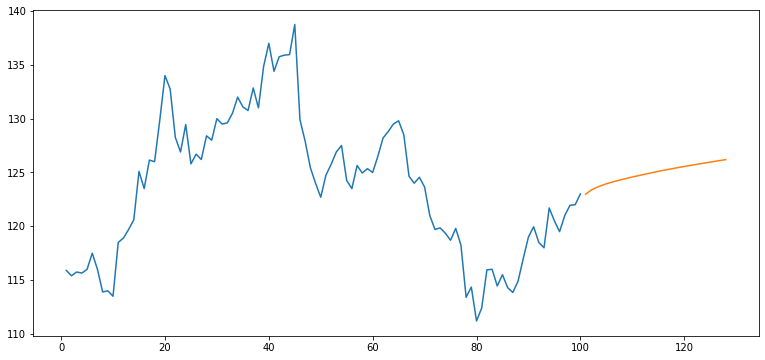

In [53]:
plt.figure(figsize=(13,6))

plt.plot(day_new, scaler.inverse_transform(df_high[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

plt.show()

# Graph of predicted values for next 30 days

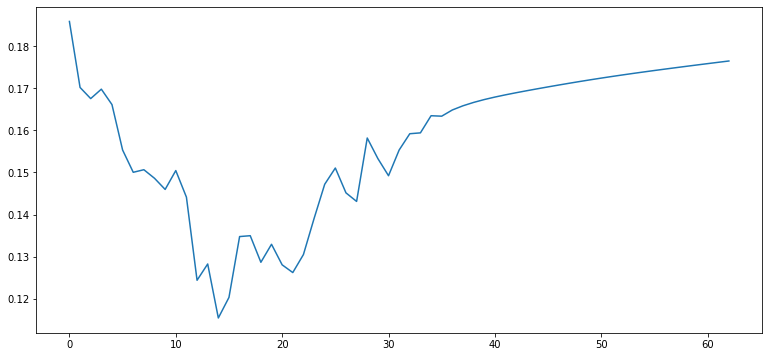

In [54]:
plt.figure(figsize=(13,6))

ds3=df_high.tolist()
ds3.extend(lst_output)
plt.plot(ds3[2000:])
plt.show()

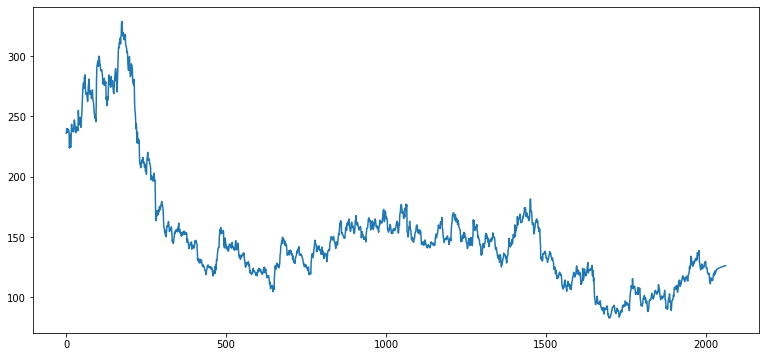

In [55]:
plt.figure(figsize=(13,6))

ds3=scaler.inverse_transform(ds3).tolist()
plt.plot(ds3)

plt.show()